In [1]:
import sys
#address to the utils file
sys.path.append('/BTNAS003/olyaeeen/Ehsan/main/jupyter/')
from utils import *
import numpy as np
import glob
import nibabel as nib
import PIL
from IPython.display import Image
import cv2
import imageio
import matplotlib.pyplot as plt
import datetime
import os

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Input, Conv3D, MaxPooling3D, UpSampling3D, concatenate
from tensorflow.keras.layers import Activation
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# specify GPU devices. "" means no GPU and the training is performed on CPU 
os.environ["CUDA_VISIBLE_DEVICES"]=""
# gpus = tf.config.list_physical_devices('GPU')
# for gpu in gpus:
#   tf.config.experimental.set_memory_growth(gpu, True)

print(tf.__version__)

2.2.0


In [2]:
# LOG_DIR = '/home/olyaeeen/Desktop/Ehsan/log/utnet' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
LOG_DIR = '/BTNAS003/olyaeeen/Ehsan/main/experiments/temp/'

#all objects data directiory
DATA_DIR='/BTNAS003/olyaeeen/Ehsan/main/data/data_all/'
img_list = sorted(glob.glob(DATA_DIR+'*-subvolume-normalized.nii.gz'))
gt_list = sorted(glob.glob(DATA_DIR+'*-subvolume-split-label-myo-fixed-tformedBack.nii.gz'))

#create required directories
log_imgs_ground_truth = LOG_DIR+'/imgs/ground_truth/'
if not os.path.exists(log_imgs_ground_truth):
    os.makedirs(log_imgs_ground_truth)

log_imgs_training = LOG_DIR+'/imgs/training/'
if not os.path.exists(log_imgs_training):
    os.makedirs(log_imgs_training)
    

CSV_LOG_DIR = LOG_DIR+'/log.log'
MODELS_DIR = LOG_DIR+'/models/'
if not os.path.exists(MODELS_DIR):
    os.makedirs(MODELS_DIR) 
  
assert(len(gt_list)==len(img_list))
gt_len = len(gt_list)
print('size of dataset is:', len(gt_list))

size of dataset is: 60


In [3]:
#patient subjects selection for validation 
valid_indxs = [5, 21,45, 58, 10]
valid_img_list = [img_list[i] for i in valid_indxs]
valid_gt_list = [gt_list[i] for i in valid_indxs]

train_img_list = img_list.copy()
train_gt_list = gt_list.copy()

for idx in sorted(valid_indxs, reverse=True):
    train_img_list.pop(idx)
    train_gt_list.pop(idx)

print(len(valid_img_list), len(train_img_list))
print(len(valid_gt_list), len(train_gt_list))

5 55
5 55


In [ ]:
# train_img_list = train_img_list[:1]
# train_gt_list = train_gt_list[:1]
# valid_img_list = valid_img_list[:1]
# valid_gt_list = valid_gt_list[:1]
# print(valid_img_list)

# print(len(valid_img_list), len(train_img_list))
# print(len(valid_gt_list), len(train_gt_list))

In [5]:
INPUT_SHAPE = (144, 144, 144)

EPOCHS = 1000
BATCH_SIZE = 1
STEP_PER_EPOCH = len(train_img_list)// BATCH_SIZE
STEP_PER_EPOCH_VALID = len(valid_gt_list)// BATCH_SIZE
CHANNELS_LAST=True
SAVE_MODEL_PERIOD = 1

tf.keras.backend.set_image_data_format('channels_last' if CHANNELS_LAST is True else 'channels_first')

In [6]:
#dample data for visualiztion during training
ds_train_sample = VolumeDataGenerator(train_img_list, train_gt_list, batch_size=BATCH_SIZE, shuffle=False, crop=True, dim_crop=INPUT_SHAPE, to_categorical=True, channels_last=CHANNELS_LAST)
ds_valid_sample = VolumeDataGenerator(valid_img_list, valid_gt_list, batch_size=BATCH_SIZE, shuffle=False, crop=False, to_categorical=True, channels_last=CHANNELS_LAST)

img_train, gt_train = next(iter(ds_train_sample))
print(img_train.shape, gt_train.shape)
iterator = iter(ds_valid_sample)
# next(iterator)
# next(iterator)
# next(iterator)
# next(iterator)
img_valid, gt_valid = next(iterator)

Training on: /BTNAS003/olyaeeen/Ehsan/main/data/data_all/pat00-subvolume-normalized.nii.gz
try 1 0.7850731867736391
(1, 144, 144, 144, 1) (1, 144, 144, 144, 9)
Training on: /BTNAS003/olyaeeen/Ehsan/main/data/data_all/pat05-subvolume-normalized.nii.gz
try 1 0.8536271058586875


In [7]:
# train and valid dataset generators
ds_train = VolumeDataGenerator(train_img_list, train_gt_list, batch_size=BATCH_SIZE, crop=True, dim_crop=INPUT_SHAPE, to_categorical=True, channels_last=CHANNELS_LAST)
ds_valid = VolumeDataGenerator(valid_img_list, valid_gt_list, batch_size=BATCH_SIZE, crop=False, to_categorical=True, channels_last=CHANNELS_LAST)

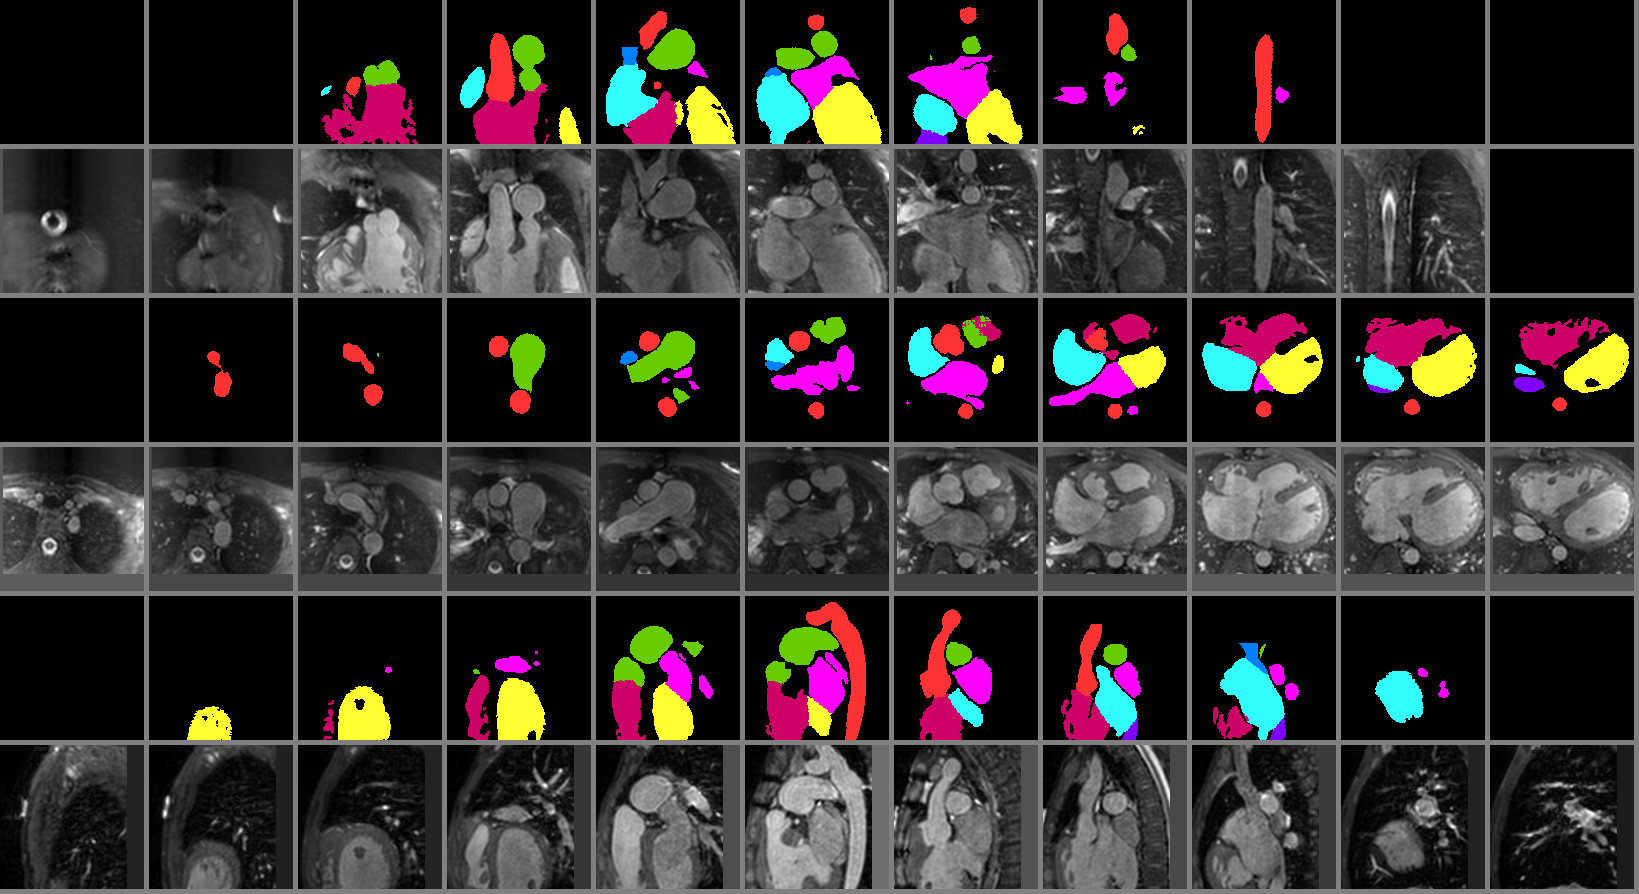

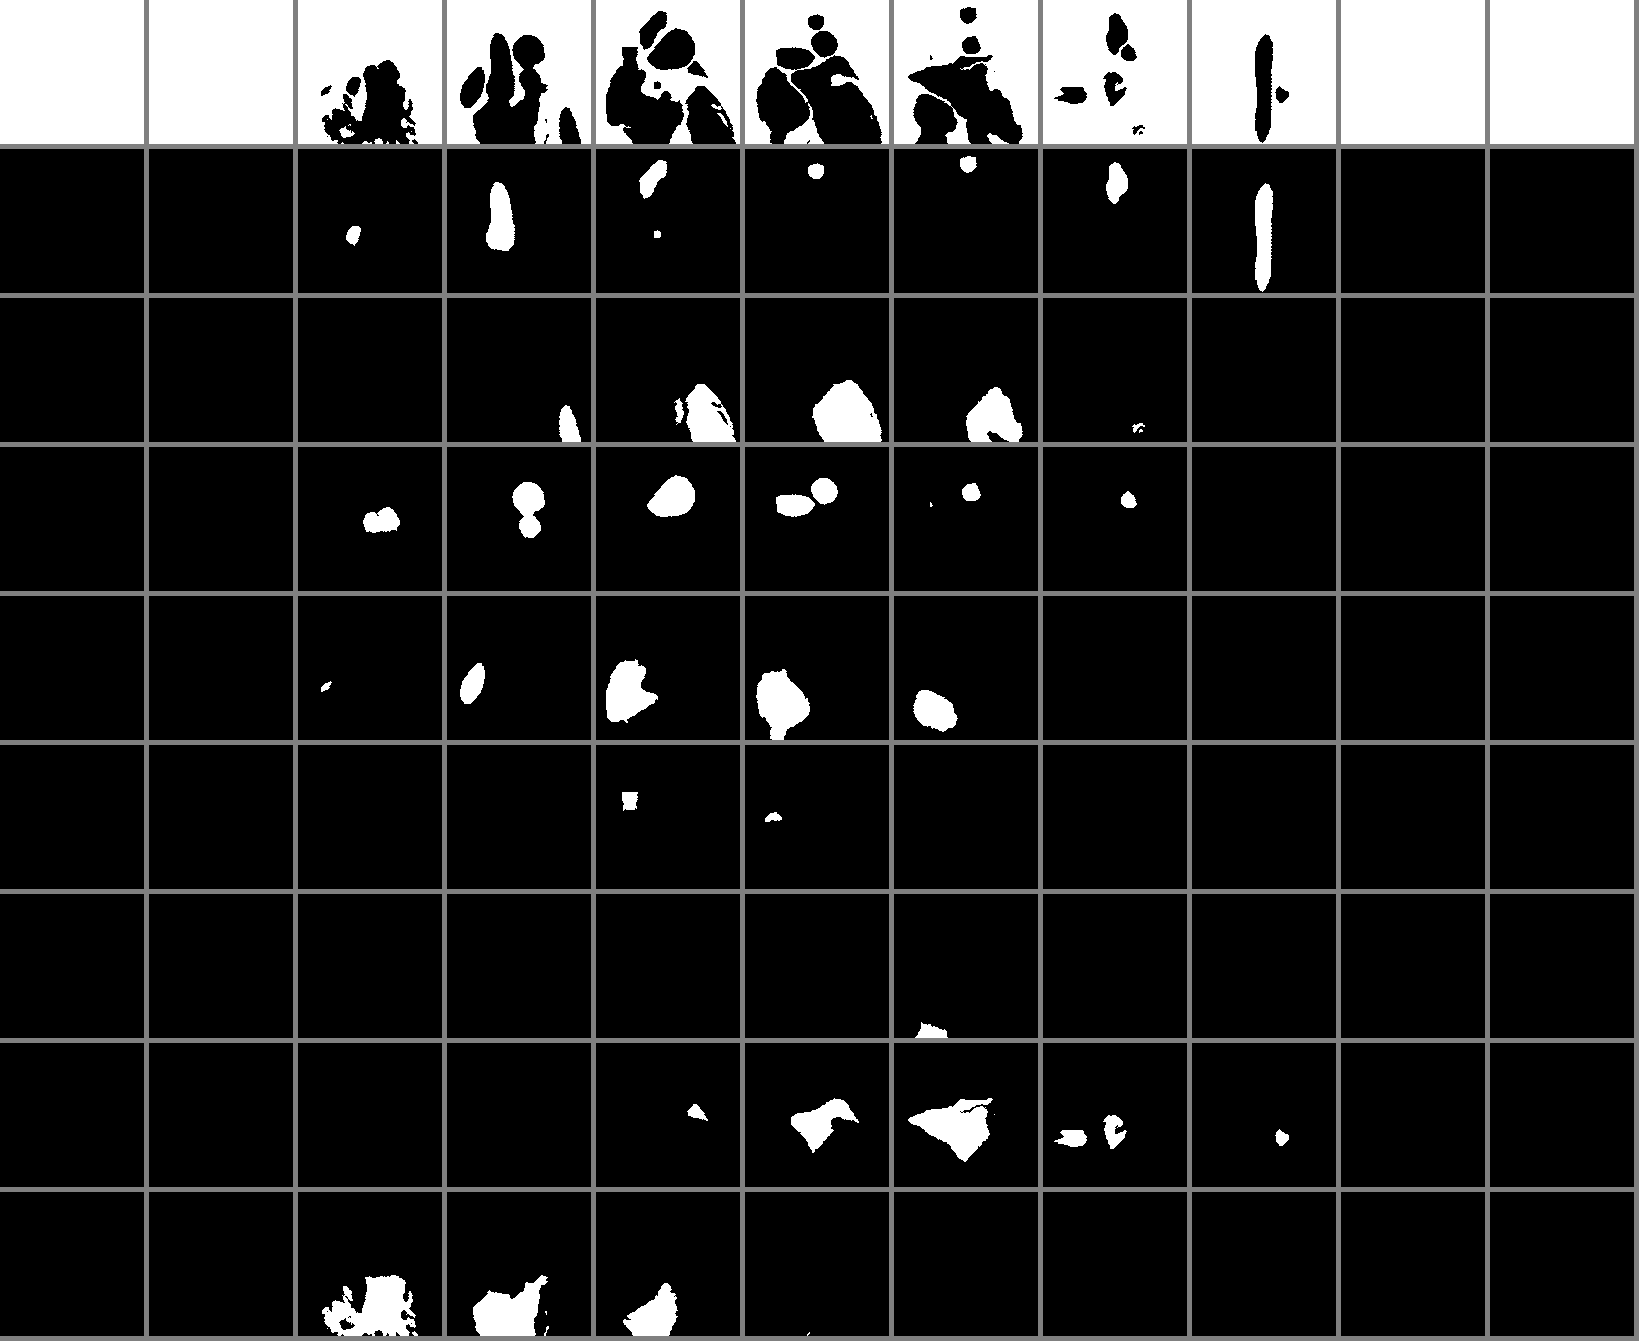

In [8]:
if CHANNELS_LAST is True:
    display(visualize_volume(img_train[0, :, :, :, 0], undo_categorical(gt_train, channels_last=CHANNELS_LAST), 10))
    display(visualize_gt(gt_train[0, :, :, :, :], num_slices=10, channels_last=CHANNELS_LAST))
else:
    display(visualize_volume(img_train[0, 0, :, :, :], undo_categorical(gt_train, channels_last=CHANNELS_LAST), 10))
    display(visualize_gt(gt_train[0, :, :, :, :], num_slices=10, channels_last=CHANNELS_LAST))


In [9]:
# if CHANNELS_LAST is True:
#     gifs = make_gif(img[0, :, :, :, 0], gt[0, :, :, :, 0])
# else:
#     gifs = make_gif(img[0, 0, :, :, :], gt[0, 0, :, :, :])

# # display(gifs[0])
# # display(gifs[1])
# # display(gifs[2])

In [10]:
class unet(object):
    def __init__(self, use_upsampling=False, learning_rate=0.001,
                 n_cl_in=1, n_cl_out=1, feature_maps = 16,
                 dropout=0.2, print_summary=False,
                 channels_last = True):

        self.channels_last = channels_last
        if channels_last:
            self.concat_axis = -1
            self.data_format = "channels_last"

        else:
            self.concat_axis = 1
            self.data_format = "channels_first"
            

        self.fms = feature_maps # 16 or 32 feature maps in the first convolutional layer

        self.use_upsampling = use_upsampling
        self.dropout = dropout
        self.print_summary = print_summary
        self.n_cl_in = n_cl_in
        self.n_cl_out = n_cl_out
        # self.loss = self.dice_coef_loss
        self.loss = self.combined_dice_ce_loss

        self.learning_rate = learning_rate
        self.optimizer = keras.optimizers.Adam(lr=self.learning_rate)

        self.metrics= [self.dice_coef, self.soft_dice_coef, "accuracy",
                 self.sensitivity, self.specificity]
        for i in range(9): self.metrics.append(self.single_layer_dice_coef(i))

        self.custom_objects = {
            "combined_dice_ce_loss": self.combined_dice_ce_loss,
            "dice_coef_loss": self.dice_coef_loss,
            "dice_coef": self.dice_coef,
            "soft_dice_coef": self.soft_dice_coef,
#             "single_layer_dice_coef" = self.single_layer_dice_coef(2),
            "sensitivity": self.sensitivity,
            "specificity": self.specificity}

        self.model = self.unet_3d()        

        
    def single_layer_dice_coef(self, label):      
        def dice_coef_single(target, prediction, label=label, axis=(1, 2, 3), smooth=0.01):
            """
            Sorenson Dice
            \frac{  2 \times \left | T \right | \cap \left | P \right |}{ \left | T \right | +  \left | P \right |  }
            where T is ground truth mask and P is the prediction mask
            """
#           prediction = tf.round(prediction)  # Round to 0 or 1
            prediction = tf.math.argmax(prediction, axis=-1)
            prediction = tf.one_hot(prediction, 9)        
            intersection = tf.reduce_sum(target * prediction, axis=axis)
            union = tf.reduce_sum(target + prediction, axis=axis)
            numerator = tf.constant(2.) * intersection + smooth
            denominator = union + smooth
            coef = numerator / denominator
            return tf.reduce_mean(coef[:, label])
        #set the name of callback
        dice_coef_single.__name__ = 'single_layer_{}'.format(label)
        return dice_coef_single

    
    def dice_coef(self, target, prediction, axis=(1, 2, 3), smooth=0.01):
        """
        Sorenson Dice
        \frac{  2 \times \left | T \right | \cap \left | P \right |}{ \left | T \right | +  \left | P \right |  }
        where T is ground truth mask and P is the prediction mask
        """
#       prediction = tf.round(prediction)  # Round to 0 or 1    
        prediction = tf.math.argmax(prediction, axis=-1)
        prediction = tf.one_hot(prediction, 9)        
        
        intersection = tf.reduce_sum(target * prediction, axis=axis)
        union = tf.reduce_sum(target + prediction, axis=axis)
        numerator = tf.constant(2.) * intersection + smooth
        denominator = union + smooth
        coef = numerator / denominator

        return tf.reduce_mean(coef)

    
    def soft_dice_coef(self, target, prediction, axis=(1, 2, 3), smooth=0.01):
        """
        Sorenson (Soft) Dice - Don't round predictions
        \frac{  2 \times \left | T \right | \cap \left | P \right |}{ \left | T \right | +  \left | P \right |  }
        where T is ground truth mask and P is the prediction mask
        """
        intersection = tf.reduce_sum(target * prediction, axis=axis)
        union = tf.reduce_sum(target + prediction, axis=axis)
        numerator = tf.constant(2.) * intersection + smooth
        denominator = union + smooth
        coef = numerator / denominator

        return tf.reduce_mean(coef)


    def dice_coef_loss(self, target, prediction, axis=(1, 2, 3), smooth=0.1):
        """
        Sorenson (Soft) Dice loss
        Using -log(Dice) as the loss since it is better behaved.
        Also, the log allows avoidance of the division which
        can help prevent underflow when the numbers are very small.
        """
        intersection = tf.reduce_sum(prediction * target, axis=axis)
        p = tf.reduce_sum(prediction, axis=axis)
        t = tf.reduce_sum(target, axis=axis)
        numerator = tf.reduce_mean(intersection + smooth)
        denominator = tf.reduce_mean(t + p + smooth)
        dice_loss = -tf.math.log(2.*numerator) + tf.math.log(denominator)

        return dice_loss


    def combined_dice_ce_loss(self, target, prediction, axis=(1, 2, 3),
                              smooth=0.1, weight=0.7):
        """
        Combined Dice and Binary Cross Entropy Loss
        """
        return weight*(1 - self.soft_dice_coef(target, prediction, axis, smooth)) + \
            (1-weight)*keras.losses.binary_crossentropy(target, prediction)


    def unet_3d(self):
        """
        3D U-Net
        """
        def ConvolutionBlock(x, name, fms, params):
            """
            Convolutional block of layers
            Per the original paper this is back to back 3D convs
            with batch norm and then ReLU.
            """
            bn_axis = 1 if self.data_format is "channels_first" else 4

            x = keras.layers.Conv3D(filters=fms, **params, name=name+"_conv0")(x)
            x = keras.layers.BatchNormalization(name=name+"_bn0", axis=bn_axis)(x)
            x = keras.layers.Activation("relu", name=name+"_relu0")(x)

            x = keras.layers.Conv3D(filters=fms, **params, name=name+"_conv1")(x)
            x = keras.layers.BatchNormalization(name=name+"_bn1", axis=bn_axis)(x)
            x = keras.layers.Activation("relu", name=name)(x)

            return x

        if self.channels_last:
            input_shape = [None, None, None, self.n_cl_in]
        else:
            input_shape = [self.n_cl_in, None, None, None]

        inputs = keras.layers.Input(shape=input_shape,
                                name="MRImages")

        params = dict(kernel_size=(3, 3, 3), activation=None,
                      padding="same", data_format=self.data_format,
                      kernel_initializer="he_uniform")

        # Transposed convolution parameters
        params_trans = dict(data_format=self.data_format,
                            kernel_size=(2, 2, 2), strides=(2, 2, 2),
                            padding="same")


        # BEGIN - Encoding path
        encodeA = ConvolutionBlock(inputs, "encodeA", self.fms, params)
        poolA = keras.layers.MaxPooling3D(name="poolA", pool_size=(2, 2, 2))(encodeA)

        encodeB = ConvolutionBlock(poolA, "encodeB", self.fms*2, params)
        poolB = keras.layers.MaxPooling3D(name="poolB", pool_size=(2, 2, 2))(encodeB)

        encodeC = ConvolutionBlock(poolB, "encodeC", self.fms*4, params)
        poolC = keras.layers.MaxPooling3D(name="poolC", pool_size=(2, 2, 2))(encodeC)

        encodeD = ConvolutionBlock(poolC, "encodeD", self.fms*8, params)
        poolD = keras.layers.MaxPooling3D(name="poolD", pool_size=(2, 2, 2))(encodeD)

        encodeE = ConvolutionBlock(poolD, "encodeE", self.fms*16, params)
        # END - Encoding path

        # BEGIN - Decoding path
        if self.use_upsampling:
            up = keras.layers.UpSampling3D(name="upE", size=(2, 2, 2),
                                       interpolation="bilinear")(encodeE)
        else:
            up = keras.layers.Conv3DTranspose(name="transconvE", filters=self.fms*8,
                                          **params_trans)(encodeE)
        concatD = keras.layers.concatenate(
            [up, encodeD], axis=self.concat_axis, name="concatD")

        decodeC = ConvolutionBlock(concatD, "decodeC", self.fms*8, params)

        if self.use_upsampling:
            up = keras.layers.UpSampling3D(name="upC", size=(2, 2, 2),
                                       interpolation="bilinear")(decodeC)
        else:
            up = keras.layers.Conv3DTranspose(name="transconvC", filters=self.fms*4,
                                          **params_trans)(decodeC)
        concatC = keras.layers.concatenate(
            [up, encodeC], axis=self.concat_axis, name="concatC")

        decodeB = ConvolutionBlock(concatC, "decodeB", self.fms*4, params)

        if self.use_upsampling:
            up = keras.layers.UpSampling3D(name="upB", size=(2, 2, 2),
                                       interpolation="bilinear")(decodeB)
        else:
            up = keras.layers.Conv3DTranspose(name="transconvB", filters=self.fms*2,
                                          **params_trans)(decodeB)
        concatB = keras.layers.concatenate(
            [up, encodeB], axis=self.concat_axis, name="concatB")

        decodeA = ConvolutionBlock(concatB, "decodeA", self.fms*2, params)

        if self.use_upsampling:
            up = keras.layers.UpSampling3D(name="upA", size=(2, 2, 2),
                                       interpolation="bilinear")(decodeA)
        else:
            up = keras.layers.Conv3DTranspose(name="transconvA", filters=self.fms,
                                          **params_trans)(decodeA)
        concatA = keras.layers.concatenate(
            [up, encodeA], axis=self.concat_axis, name="concatA")

        # END - Decoding path

        convOut = ConvolutionBlock(concatA, "convOut", self.fms, params)

        prediction = keras.layers.Conv3D(name="PredictionMask",
                                     filters=self.n_cl_out, kernel_size=(1, 1, 1),
                                     data_format=self.data_format,
                                     activation="sigmoid")(convOut)

        model = keras.models.Model(inputs=[inputs], outputs=[prediction])

        if self.print_summary:
            model.summary()

        return model


    def sensitivity(self, target, prediction, axis=(1, 2, 3), smooth=0.0001):
        """
        Sensitivity
        """
        prediction = tf.round(prediction)

        intersection = tf.reduce_sum(prediction * target, axis=axis)
        coef = (intersection + smooth) / (tf.reduce_sum(target,
                                                        axis=axis) + smooth)
        return tf.reduce_mean(coef)


    def specificity(self, target, prediction, axis=(1, 2, 3), smooth=0.0001):
        """
        Specificity
        """
        prediction = tf.round(prediction)

        intersection = tf.reduce_sum(prediction * target, axis=axis)
        coef = (intersection + smooth) / (tf.reduce_sum(prediction,
                                                        axis=axis) + smooth)
        return tf.reduce_mean(coef)

In [11]:
unet_model = unet(use_upsampling=False,
                  learning_rate=0.01,
                  n_cl_in=1,
                  n_cl_out=9,  # single channel (greyscale)
                  feature_maps = 16,
                  dropout=0.2,
                  print_summary=True,
                  channels_last = CHANNELS_LAST)  # channels first or last

unet_model.model.compile(optimizer=unet_model.optimizer,
              loss=unet_model.loss,
              metrics=unet_model.metrics)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
MRImages (InputLayer)           [(None, None, None,  0                                            
__________________________________________________________________________________________________
encodeA_conv0 (Conv3D)          (None, None, None, N 448         MRImages[0][0]                   
__________________________________________________________________________________________________
encodeA_bn0 (BatchNormalization (None, None, None, N 64          encodeA_conv0[0][0]              
__________________________________________________________________________________________________
encodeA_relu0 (Activation)      (None, None, None, N 0           encodeA_bn0[0][0]                
______________________________________________________________________________________________

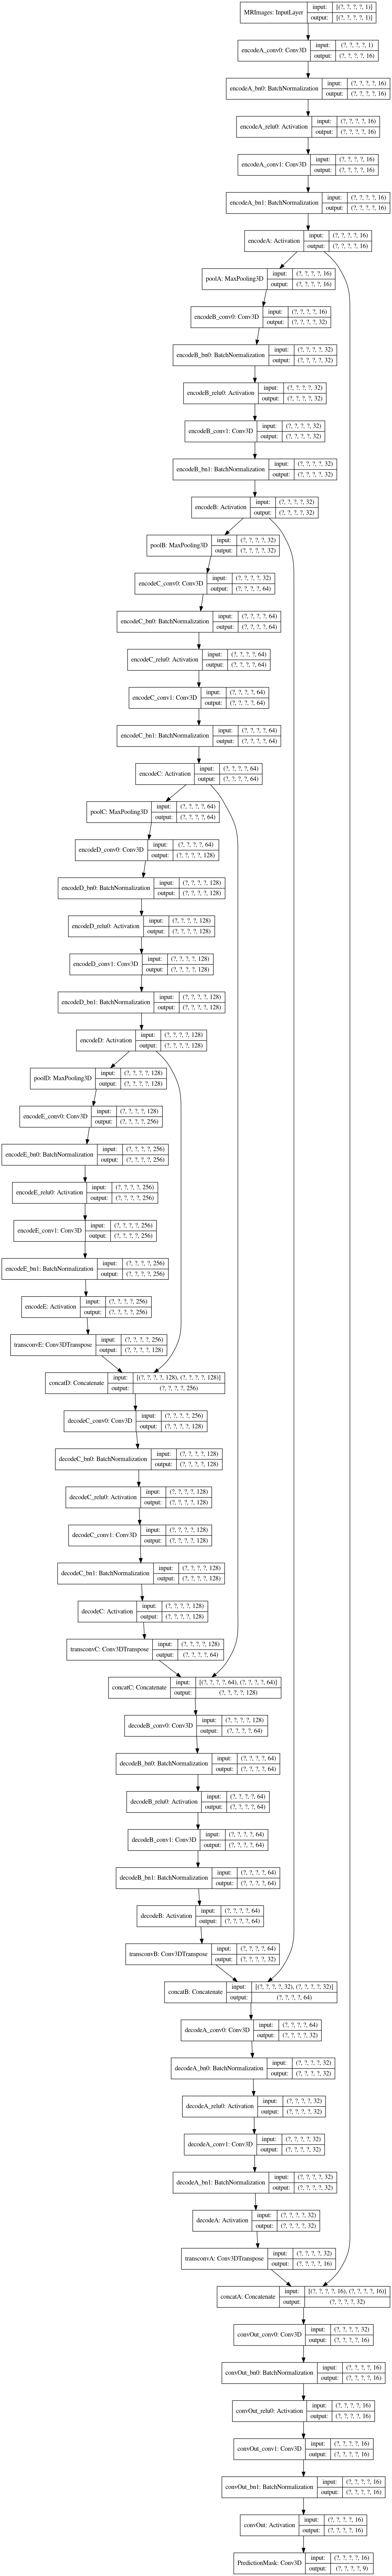

In [12]:
tf.keras.utils.plot_model(unet_model.model, show_shapes=True)

In [13]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=LOG_DIR, histogram_freq=1, profile_batch = '2, 200')
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=LOG_DIR)

# Creates a file writer for the log directory.
file_writer = tf.summary.create_file_writer(LOG_DIR)

# model checkpoint
saved_models = sorted(glob.glob(MODELS_DIR+'*.h5'))
initial_epoch=0
if len(saved_models) is not 0:
  last_epoch_name = saved_models[-1]
  model = tf.keras.models.load_model(last_epoch_name, custom_objects=unet_model.custom_objects)
  initial_epoch = int(str(last_epoch_name)[-9:-3])
filepath = MODELS_DIR+"{epoch:06d}.h5"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=False, save_freq=gt_len*SAVE_MODEL_PERIOD)

# csv logger
csv_logger = tf.keras.callbacks.CSVLogger(CSV_LOG_DIR, append=True)


# Keep reducing learning rate if we get to plateau
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.2,
                                          patience=5, min_lr=0.0001)




In [14]:
    
class DisplayCallback(tf.keras.callbacks.Callback):
    
  def on_train_begin(self, logs=None):
    # clear_output(wait=True)
    img_train_temp = img_train[0, :, :, :, 0] if CHANNELS_LAST is True else img_train[0, 0, :, :, :]
    img_valid_temp = img_valid[0, :, :, :, 0] if CHANNELS_LAST is True else img_valid[0, 0, :, :, :]
    
    volume_disp_train = visualize_volume(img_train_temp, undo_categorical(gt_train, channels_last=CHANNELS_LAST), 10)
    gt_disp_train = visualize_gt(gt_train[0, :, :, :, :], num_slices=10, channels_last=CHANNELS_LAST)
    
    volume_disp_valid = visualize_volume(img_valid_temp, undo_categorical(gt_valid, channels_last=CHANNELS_LAST), 10)
    gt_disp_valid = visualize_gt(gt_valid[0, :, :, :, :], num_slices=10, channels_last=CHANNELS_LAST)
            
        
    volume_disp_train.save(log_imgs_ground_truth+'0_volume_train.jpg')
    gt_disp_train.save(log_imgs_ground_truth+'1_gt_train.jpg')
    volume_disp_valid.save(log_imgs_ground_truth+'2_volume_valid.jpg')
    gt_disp_valid.save(log_imgs_ground_truth+'3_gt_valid.jpg')

    with file_writer.as_default():
      tf.summary.image("ground_truth/0_volume_train", np.expand_dims(np.array(volume_disp_train), 0), step=0)
      tf.summary.image("ground_truth/1_gt_train",  np.expand_dims(np.expand_dims(np.array(gt_disp_train), -1), 0), step=0)
        
      tf.summary.image("ground_truth/2_volume_valid", np.expand_dims(np.array(volume_disp_valid), 0), step=0)
      tf.summary.image("ground_truth/3_gt_valid",  np.expand_dims(np.expand_dims(np.array(gt_disp_valid), -1), 0), step=0)
        
        
  def on_epoch_end(self, epoch, logs=None):
    # clear_output(wait=True)
    out_train = unet_model.model.predict(img_train)
    out_train = np.argmax(out_train, axis=-1)
    out_train = tf.keras.utils.to_categorical(out_train, num_classes=9)
    
    out_valid = unet_model.model.predict(img_valid)
    out_valid = np.argmax(out_valid, axis=-1)
    out_valid = tf.keras.utils.to_categorical(out_valid, num_classes=9)
    
    img_train_temp = img_train[0, :, :, :, 0] if CHANNELS_LAST is True else img_train[0, 0, :, :, :]
    img_valid_temp = img_valid[0, :, :, :, 0] if CHANNELS_LAST is True else img_valid[0, 0, :, :, :]
    
    volume_disp_train = visualize_volume(img_train_temp, undo_categorical(gt_train, channels_last=CHANNELS_LAST), 10)
    gt_disp_train = visualize_gt(out_train[0, :, :, :, :], num_slices=10, channels_last=CHANNELS_LAST)
    
    volume_disp_valid = visualize_volume(img_valid_temp, undo_categorical(out_valid, channels_last=CHANNELS_LAST), 10)
    gt_disp_valid = visualize_gt(out_valid[0, :, :, :, :], num_slices=10, channels_last=CHANNELS_LAST)
    
    volume_disp_train.save(log_imgs_training+'{}_volume_train.jpg'.format(str(epoch)))
    gt_disp_train.save(log_imgs_training+'{}_gt_train.jpg'.format(str(epoch)))
    volume_disp_valid.save(log_imgs_training+'{}_volume_valid.jpg'.format(str(epoch)))
    gt_disp_valid.save(log_imgs_training+'{}_gt_valid.jpg'.format(str(epoch)))

    with file_writer.as_default():
      tf.summary.image("training/0_volume_train", np.expand_dims(np.array(volume_disp_train), 0), step=epoch)
      tf.summary.image("training/1_gt_train",  np.expand_dims(np.expand_dims(np.array(gt_disp_train), -1), 0), step=epoch)
        
      tf.summary.image("training/2_volume_valid", np.expand_dims(np.array(volume_disp_valid), 0), step=epoch)
      tf.summary.image("training/3_gt_valid",  np.expand_dims(np.expand_dims(np.array(gt_disp_valid), -1), 0), step=epoch)
        

In [ ]:
history = unet_model.model.fit(ds_train,
        steps_per_epoch=STEP_PER_EPOCH,#STEP_PER_EPOCH
        epochs=EPOCHS, 
        initial_epoch=initial_epoch,
        validation_data=ds_valid, 
        validation_steps=STEP_PER_EPOCH_VALID,                       
        callbacks=[tensorboard_callback, 
                   model_checkpoint, 
                   csv_logger, 
                   DisplayCallback(), 
                   reduce_lr])